In [1]:
import mysql.connector as connection
import pandas as pd
import datetime as dt
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt

In [2]:
mydb = connection.connect(host="localhost", database = 'sensoric_data',user="root", passwd="ajopajo",use_pure=True)

In [3]:
query = '''
SELECT 
    REPLACE(name,'_DIST_BOX', '') as Name,
    DecimalValue,
    Time
FROM
    sensoric_data.thermomapping
'''

In [4]:
df = pd.read_sql(query,mydb)
df.head()

,Name,DecimalValue,Time
0,136,17.94,2020-12-17 13:43:03
1,136,18.25,2020-12-17 13:44:09
2,136,18.37,2020-12-17 13:45:54
3,136,18.77,2020-12-17 13:48:07
4,136,18.92,2020-12-17 13:49:13


In [9]:
df = pd.read_csv('all_data.csv')

In [10]:
# Parse time from column
df['Time'] = pd.to_datetime(df['Time'])
# Save exact time (avoid resampling data loss)
df['Time_exact'] = df['Time']
# Set date as index
df.set_index('Time', inplace=True)

In [11]:
# Resample to hour intervals
resampled = df.groupby('Name', as_index=False).resample('H').first().reset_index()
resampled.drop('Unnamed: 0', axis='columns', inplace=True)

Name
136    AxesSubplot(0.125,0.2;0.775x0.68)
137    AxesSubplot(0.125,0.2;0.775x0.68)
138    AxesSubplot(0.125,0.2;0.775x0.68)
141    AxesSubplot(0.125,0.2;0.775x0.68)
142    AxesSubplot(0.125,0.2;0.775x0.68)
144    AxesSubplot(0.125,0.2;0.775x0.68)
145    AxesSubplot(0.125,0.2;0.775x0.68)
146    AxesSubplot(0.125,0.2;0.775x0.68)
148    AxesSubplot(0.125,0.2;0.775x0.68)
149    AxesSubplot(0.125,0.2;0.775x0.68)
150    AxesSubplot(0.125,0.2;0.775x0.68)
Name: DecimalValue, dtype: object

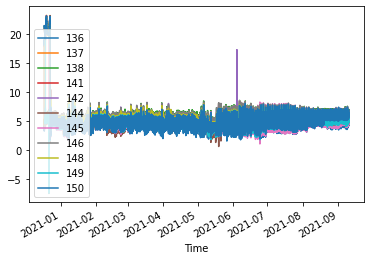

In [13]:
# Plot all intervals
df.groupby('Name')['DecimalValue'].plot(legend=True)

In [16]:
# Time interval of dataset
print (df.index.min())
print (df.index.max())
print (df.index.max() - df.index.min())

2020-12-17 13:43:03
2021-09-09 23:59:07
266 days 10:16:04


In [102]:
# Select sample 
start_date = '2021-09-07'
end_date = '2021-09-08'
mask = (resampled['Time_exact'] > start_date) & (resampled['Time_exact'] <= end_date)
a = resampled.loc[mask]

In [103]:

a.groupby('Name').agg(lambda x: x.iloc[5])

,level_0,Time,DecimalValue,Time_exact
Name,,,,
136.0,0,2021-09-07 05:00:00,5.07,2021-09-07 05:00:50
137.0,1,2021-09-07 05:00:00,5.35,2021-09-07 05:00:58
138.0,2,2021-09-07 05:00:00,5.66,2021-09-07 05:00:51
141.0,3,2021-09-07 05:00:00,5.00,2021-09-07 05:00:55
142.0,4,2021-09-07 05:00:00,5.32,2021-09-07 05:00:53
144.0,5,2021-09-07 05:00:00,5.08,2021-09-07 05:00:57
145.0,6,2021-09-07 05:00:00,5.16,2021-09-07 05:00:58
146.0,7,2021-09-07 05:00:00,5.48,2021-09-07 05:00:57
148.0,8,2021-09-07 05:00:00,5.39,2021-09-07 05:00:56


In [115]:
temp = a.groupby('Name').agg(lambda x: x.iloc[3])['DecimalValue'].to_numpy()
max = np.amax(temp)

In [116]:
xy = np.array([[0.5,1],
              [0.25, 1], # 136
              [0.5, 0],  # 138
              
               [0.5, 0],  # 141
              [0, 1],    # 142
              [0.5, 1],  # 144
              [0.8, 0],  # 145
              [0,0.5],   # 146
              [0.2, 0],  # 148
              [0.8,1],   # 149
              [0.2,0]])  # 150
#xy[:,0] = np.multiply(xy[:,0], 3.6)
#xy[:,1] = np.multiply(xy[:,1], 1.8)
print(xy)

[[0.5  1.  ]
 [0.25 1.  ]
 [0.5  0.  ]
 [0.5  0.  ]
 [0.   1.  ]
 [0.5  1.  ]
 [0.8  0.  ]
 [0.   0.5 ]
 [0.2  0.  ]
 [0.8  1.  ]
 [0.2  0.  ]]


In [117]:
arr = []
for x in temp:
    arr.append([x])
arr = np.array(arr)
print(temp)

[4.81 5.12 5.54 4.77 5.01 4.92 4.92 5.26 5.34 4.9  5.48]


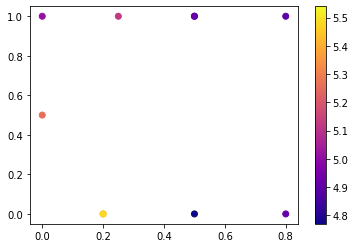

In [118]:
x = xy[:,0]
y = xy[:,1]
fig = plt.figure()
plt.scatter(x, y, c=temp, cmap='plasma')
plt.colorbar()
# plt.xlim(max(x),min(x))
# plt.ylim(max(y),min(y))
plt.show()

In [119]:
# Convert to ot samples
input_train = ot.Sample(xy)
output_train = ot.Sample(arr)

In [120]:
inputDimension = 2
basis = ot.ConstantBasisFactory(inputDimension).build()
covariance_kernel = ot.SquaredExponential([1.]*inputDimension, [1.0])
algo = ot.KrigingAlgorithm(input_train, output_train,
                           covariance_kernel, basis)

In [121]:
algo.run()
result = algo.getResult()
krigingMetamodel = result.getMetaModel()

In [122]:
myInterval = ot.Interval([0., 0.], [1., 1.])
# Define the number of interval in each direction of the box
nx = 200
ny = 100
myIndices = [nx-1, ny-1]
myMesher = ot.IntervalMesher(myIndices)
myMeshBox = myMesher.build(myInterval)

In [123]:
vertices = myMeshBox.getVertices()
predictions = krigingMetamodel(vertices)

In [124]:
X = np.array(vertices[:,0]).reshape((ny,nx))
Y = np.array(vertices[:,1]).reshape((ny,nx))
predictions_array = np.array(predictions).reshape((ny,nx))

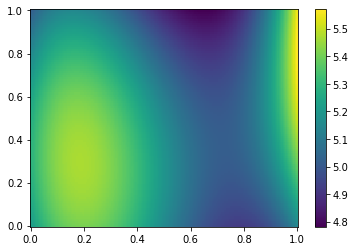

In [125]:
fig = plt.figure()
plt.pcolor(X, Y, predictions_array, shading='auto')
plt.colorbar()
plt.show()

Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 6.784612474569862e-09
Full Sill: 0.07296340498464608
Range: 1.1650574670887193
Nugget: 0.07296339820003361 

Calculating statistics on variogram model fit...
Q1 = 0.5470199045644196
Q2 = 1.0052375358166203
cR = 0.09529517723143546 

Initializing drift terms...
Implementing regional linear drift.
Executing Universal Kriging...



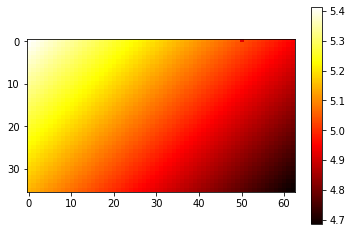

In [126]:
from pykrige.uk import UniversalKriging
import numpy as np

gridx = np.arange(0.0, 1, 0.016)
gridy = np.arange(0.0, 1, 0.028)


UK = UniversalKriging(xy[:, 0], xy[:, 1], temp, variogram_model='gaussian',
                      drift_terms=['regional_linear'], verbose=True)


z, ss = UK.execute('grid', gridx, gridy)


plt.imshow(z, cmap='hot')
plt.colorbar()
plt.show()

In [140]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

In [141]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi


In [161]:
    
    nx, ny = 50, 25 
    x, y, z = (xy[:,0], xy[:,0], temp)
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    # Calculate IDW
    grid1 = simple_idw(x,y,z,xi,yi)

C:\Users\AJO\AppData\Local\Temp/ipykernel_26992/1403982076.py:5: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / dist
C:\Users\AJO\AppData\Local\Temp/ipykernel_26992/1403982076.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights /= weights.sum(axis=0)


In [162]:
a = np.reshape(grid1, (ny, nx))

In [163]:
print(a)

[[       nan 5.1411362  5.14665132 ... 5.10273646 5.10159349 5.10051059]
 [5.14686974 5.14894556 5.15272972 ... 5.10060212 5.09946575 5.09839321]
 [5.15663297 5.15898714 5.16229469 ... 5.09817901 5.09706571 5.09601889]
 ...
 [5.10532524 5.10431999 5.10323912 ... 4.9810547  4.97689971 4.97489192]
 [5.10278544 5.10177514 5.10069732 ... 4.96085283 4.95226911 4.94830348]
 [5.10051059 5.09950493 5.09843896 ... 4.94765873 4.93062428        nan]]


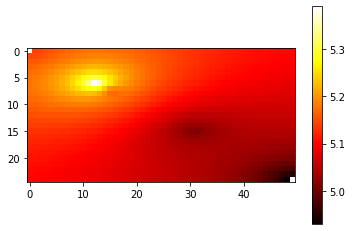

In [164]:
plt.imshow(a, cmap='hot')
plt.colorbar()
plt.show()

In [180]:

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
from scipy.interpolate import griddata

grid_z0 = griddata(xy, temp, (grid_x, grid_y), method='nearest')

grid_z1 = griddata(xy, temp, (grid_x, grid_y), method='linear')

grid_z2 = griddata(xy, temp, (grid_x, grid_y), method='cubic')

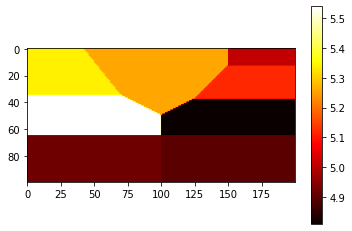

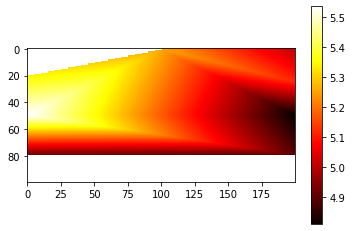

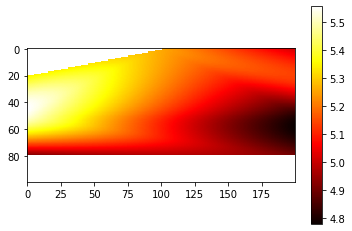

In [181]:
plt.imshow(grid_z0, cmap='hot')
plt.colorbar()
plt.show()

plt.imshow(grid_z1, cmap='hot')
plt.colorbar()
plt.show()

plt.imshow(grid_z2, cmap='hot')
plt.colorbar()
plt.show()